# Convolutional AE con Keras

https://blog.keras.io/building-autoencoders-in-keras.html

In [14]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

In [7]:
# MODELO

# ENCODER
input_img = Input(shape=(32, 32, 3))
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# DECODER
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)


In [22]:
from keras import layers
import keras


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model

img_size = (32,32)
num_classes = 3
# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_22 (Conv2D)          (None, 16, 16, 32)           896       ['input_5[0][0]']             
                                                                                                  
 batch_normalization_1 (Bat  (None, 16, 16, 32)           128       ['conv2d_22[0][0]']           
 chNormalization)                                                                                 
                                                                                                  
 activation_2 (Activation)   (None, 16, 16, 32)           0         ['batch_normalization_1[

In [25]:
opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='mse')

In [10]:
# DATOS
from keras.datasets import cifar10
import numpy as np

(x_train, _), (x_test, _) = cifar10.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 32, 32, 3))
x_test = np.reshape(x_test, (len(x_test), 32, 32, 3))

170498071/170498071 [==============================] - 6s 0us/step


In [11]:
x_train_noise = x_train.copy() + 0.1*np.random.randn(*x_train.shape)

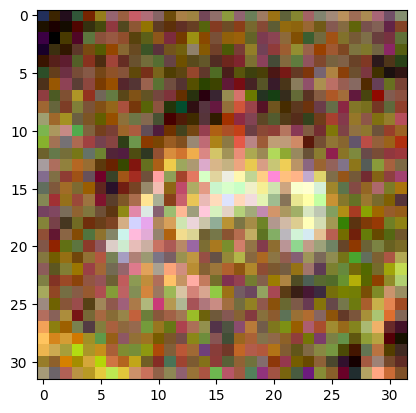

In [24]:
plt.imshow(x_train_noise[0],vmin=0,vmax=1)

In [26]:
# ENTRENAMIENTO
model.fit(x_train_noise, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/100
391/391 [==============================] - 34s 46ms/step - loss: 0.0967 - val_loss: 0.0871
Epoch 2/100
391/391 [==============================] - 14s 35ms/step - loss: 0.0812 - val_loss: 0.0807
Epoch 3/100
391/391 [==============================] - 14s 35ms/step - loss: 0.0799 - val_loss: 0.0802
Epoch 4/100
391/391 [==============================] - 14s 35ms/step - loss: 0.0794 - val_loss: 0.0798
Epoch 5/100
391/391 [==============================] - 13s 34ms/step - loss: 0.0791 - val_loss: 0.0796
Epoch 6/100
391/391 [==============================] - 14s 36ms/step - loss: 0.0789 - val_loss: 0.0794
Epoch 7/100
391/391 [==============================] - 13s 34ms/step - loss: 0.0788 - val_loss: 0.0793
Epoch 8/100
391/391 [==============================] - 14s 36ms/step - loss: 0.0787 - val_loss: 0.0792
Epoch 9/100
391/391 [==============================] - 14s 35ms/step - loss: 0.0786 - val_loss: 0.0791
Epoch 10/100
391/391 [==============================] - 14s 35ms/step - l

KeyboardInterrupt: 

In [17]:
# TEST
x_test_noise = x_test + 0.1*np.random.randn(*x_test.shape)

decoded_imgs = autoencoder.predict(x_test_noise)

313/313 [==============================] - 1s 2ms/step


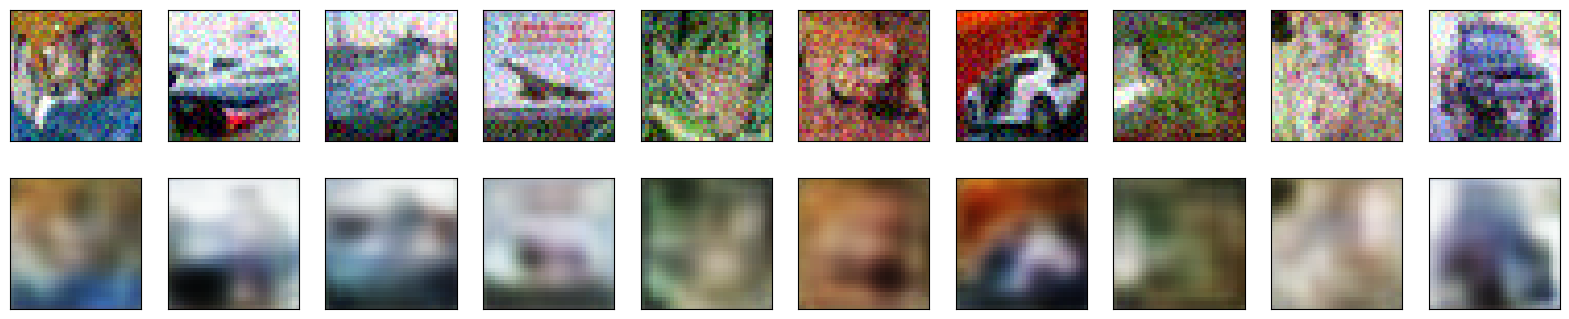

In [18]:
import matplotlib.pyplot as plt

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noise[i],vmin=0,vmax=1)

    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruccion
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i],vmin=0,vmax=1)

    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()